In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!pip install morphopy


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
!pwd

/home/pchaurasia/CodingWorkspace/work/morphvae


Experiment 1: Reproducing the model, getting a baseline using MorphVAE from the implementation listed here: [berenslab/morphvae](https://github.com/berenslab/morphvae/blob/master/models.py)

In [6]:
#Initialize Parameters
from pathlib import Path
BASE_DRIVE_DIR = Path('./data').resolve()

assert BASE_DRIVE_DIR.exists(), "Error in base dir. Did you mount drive?"
print(BASE_DRIVE_DIR)

SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/pchaurasia/CodingWorkspace/work/morphvae/data


#Create toy data

In [7]:
from utils.toy_data import generate_toy_data, plot_population_sample


#If you run into any bugs, replace line 74 of training_utils with this:     bct = np.array(np.sum(nx.adjacency_matrix(T)[:, index_order][index_order, :].T, axis=0))[0]

np.random.seed(17)
population_parameter=[dict(N=400, V=199, lam=1, height=10, width=10, depth=10, directions=[2,4], min_degree=-50, max_degree=50),
                       dict(N=400, V=199, lam=2, height=10, width=10,depth=10, directions=[2,4], min_degree=-50, max_degree=50),
                      dict(N=400, V=199, lam=3, height=10, width=10,depth=10, directions=[2,4], min_degree=-80, max_degree=100)]
_ , _ , neurons = generate_toy_data(population_parameter, with_pos=False)

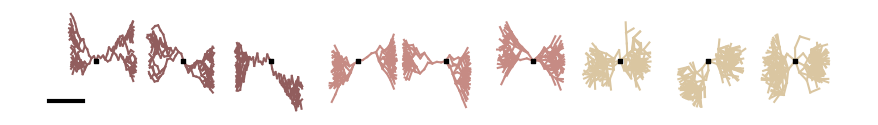

In [8]:
np.random.seed(11)
fig = plot_population_sample(population_parameter, n_samples=3)
fig.gca().set_aspect('equal')
fig.gca().axis('off')
fig.gca().plot([-7,-2],[-6,-6], c='k', linewidth=3)
plt.tight_layout()

In [9]:
# sample RANDOM walks THIS BLOCK IS EXPECTED TO NOT WORK
import multiprocessing
from utils.rw_utils import get_rw_representation, get_walk_representation

np.random.seed(17)

n_walks=256
N = len(neurons)
NUM_CORES = 15

for walk_length in [8,16,32]:
    rw_list = []
    with multiprocessing.Pool(NUM_CORES) as pool:
        rw_list += pool.map(get_rw_representation, neurons)
    RW_representation = np.array([e[0] for e in rw_list])

    with open(BASE_DRIVE_DIR / '/data/toy_data/3_populations/walk_representation_%i.npy'%walk_length, 'wb') as f:
        np.save(f, walk_representation)

NotImplementedError: We have not yet implemented 1D sparse slices; please index using explicit indices, e.g. `x[:, [0]]`

In [10]:
# Load in the walk representation
folder = '3_populations'

pth = './data/toy_data/%s/walk_representation_32.npy'%folder


with open(pth, 'rb') as f:
    walk_representation = np.load(f)

walk_representation

array([[[[ 0.  ,  0.  ,  0.  ],
         [-0.35, -1.65,  0.92],
         [-0.9 , -1.41,  1.28],
         ...,
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf]],

        [[ 0.  ,  0.  ,  0.  ],
         [-0.35, -1.65,  0.92],
         [-0.9 , -1.41,  1.28],
         ...,
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf]],

        [[ 0.  ,  0.  ,  0.  ],
         [ 0.46, -1.25,  0.12],
         [ 0.86,  0.27, -0.14],
         ...,
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf]],

        ...,

        [[ 0.  ,  0.  ,  0.  ],
         [-0.35, -1.65,  0.92],
         [-0.9 , -1.41,  1.28],
         ...,
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf],
         [ -inf,  -inf,  -inf]],

        [[ 0.  ,  0.  ,  0.  ],
         [ 0.46, -1.25,  0.12],
         [ 0.86,  0.27, -0.14],
         ...,
         [ -inf,  -inf,  -inf],
         [ -

In [11]:
def scale(X,scale=(.1,3)):
    a = scale[0]
    b = scale[1]
    s = a + (b-a)*torch.rand(1)
    return X*s


In [12]:
from torchvision.transforms import Lambda
rand_scaling = Lambda(scale)

In [13]:
#Create a dataset
from utils.training_utils import create_Seq2SeqDataset

# create Seq2Seq data set
MASKING_ELEMENT = 0
#true_labels = torch.Tensor([0]*300 + [1]*300 + [2]*300 + [3]*300 + [4]*300).to(torch.long) # when 5 population data is loaded
true_labels = torch.Tensor([0]*400 + [1]*400 + [2]*400).to(torch.long)

transform = rand_scaling
SeqDS_scaled = create_Seq2SeqDataset(walk_representation, true_labels, MASKING_ELEMENT, transform=transform)
SeqDS_nonscaled = create_Seq2SeqDataset(walk_representation, true_labels, MASKING_ELEMENT, transform=None)

mask = walk_representation[:,:,:,0] != np.infty*-1
seq_lengths = torch.Tensor(mask.sum(axis=2))


In [14]:
np.random.seed(17)

import pickle
from torch.utils.data.sampler import SubsetRandomSampler

BATCH_SIZE = 128
N, n_walks, walk_length, output_dim = walk_representation.shape

N_train = 750
N_val = 250
train_index = np.random.choice(range(N), size=N_train, replace=False)
val_index = np.random.choice(list(set(range(N)) - set(train_index)), size=N_val, replace=False)
test_index = list(set(range(N)) - set(train_index) -set(val_index))

train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)
test_sampler = SubsetRandomSampler(test_index)


train_iterator = torch.utils.data.DataLoader(SeqDS_nonscaled, batch_size=BATCH_SIZE,
                                               sampler=train_sampler)
val_iterator = torch.utils.data.DataLoader(SeqDS_nonscaled, batch_size=len(val_index),
                                           sampler=val_sampler)
test_iterator= torch.utils.data.DataLoader(SeqDS_nonscaled, batch_size=len(test_index),
                                           sampler=test_sampler)


# save the iterator
prefix = ''
with open('./data/toy_data/%s/iterator/%sval_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(val_iterator, f)

with open('./data/toy_data/%s/iterator/%stest_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(test_iterator, f)
with open('./data/toy_data/%s/iterator/%strain_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(train_iterator, f)


train_iterator = torch.utils.data.DataLoader(SeqDS_scaled, batch_size=BATCH_SIZE,
                                               sampler=train_sampler)
val_iterator = torch.utils.data.DataLoader(SeqDS_scaled, batch_size=BATCH_SIZE,
                                           sampler=val_sampler)
test_iterator= torch.utils.data.DataLoader(SeqDS_scaled, batch_size=BATCH_SIZE,
                                           sampler=test_sampler)
# save the iterator
prefix = 'scaling_'
with open('./data/toy_data/%s/iterator/%sval_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(val_iterator, f)
    print("dump")
with open('./data/toy_data/%s/iterator/%stest_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(test_iterator, f)
    print("dump")
with open('./data/toy_data/%s/iterator/%strain_iterator.pkl'%(folder, prefix), 'wb') as f:
    pickle.dump(train_iterator, f)
    print("dump")

dump
dump
dump


In [15]:
INPUT_DIM = 3
lr = 1e-2                           # learning rate
NUM_LAYERS = 2
NUM_CLASSES = 3
N_EPOCHS = 150

In [16]:
import os
os.path.exists('./data/toy_data/3_populations/iterator')

True

In [17]:
train_iterator


In [18]:
val_iterator


In [19]:
one_sample = next(iter(train_iterator))


In [20]:
one_sample[4]

tensor([1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 1, 0,
        1, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1,
        0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0,
        1, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2,
        1, 0, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1,
        2, 0, 1, 1, 2, 1, 0, 2])

In [21]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

In [22]:
emb_dim = 32
latent_dim = 32
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [23]:
NUM_CLASSES

3

In [24]:
from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.vmf_batch import vMF

enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 45.709938049316406


In [25]:
torch.cuda.empty_cache()

In [26]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim

    return RCL

In [27]:
N_EPOCHS= 150


save_path_model= './models/toy_data/scratch/%s/vae_frac%.1f_scaled_best_run%i.pt'
save_path_losses = './models/toy_data/scratch/%s/losses_frac%.1f_scaled_run%i.npy'
save_path_elapsed_time = './models/toy_data/scratch/%s/elapsed_time_frac%.1f_scaled_run%i.npy'
part = 'toy_data'

os.makedirs('./models/toy_data/scratch/toy_data', exist_ok = True)


import torch.optim as optim
from utils.training_utils import train, evaluate

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

#If you run into errors, replace line 289 in models.py with the following
#        hidden, cell = self.encoder(src,src_len.to("cpu"))

for frac in [0.]:
    runs = range(1,4)

    for run in runs:


        if os.path.exists(save_path_model%(part,frac,run)):
            state_dict = torch.load(save_path_model%(part,frac,run))
        else:
            state_dict = None
        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
        # load pre-trained model
        if state_dict is not None:
            model.load_state_dict(state_dict['model_state_dict'])

            optimizer.load_state_dict(state_dict['optimizer_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            losses = np.load(save_path_losses%(part, frac, run))
            elapsed_time = np.load(save_path_elapsed_time%(part, frac, run))

            last_epoch = state_dict['epoch']
            training = list(losses[:last_epoch,:2])
            validation = list(losses[:last_epoch,2:])

            best_test_loss = losses[:,2].min()

        else:
            model.apply(init_weights)
            classifier.apply(init_weights)
            best_test_loss = np.infty

            training = []
            validation=[]
            last_epoch = 0
            elapsed_time = np.zeros((N_EPOCHS,))


        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')


        for e in range(last_epoch, N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer,
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)

            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e] = start.elapsed_time(end) # milliseconds

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val

            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, \
                  Time elapsed [s]: {elapsed_time[e]/1000:.2f}')



            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(part,frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification losss
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(part,frac, run),losses)
                np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)



        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(part,frac, run), losses)
        np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)

torch.cuda.empty_cache()

Epoch 0, Train Loss: 4801.96, Val Loss: 17642.11,                   Time elapsed [s]: 34.31
Epoch 1, Train Loss: 3830.72, Val Loss: 18948.20,                   Time elapsed [s]: 33.76
Epoch 2, Train Loss: 3321.24, Val Loss: 13184.52,                   Time elapsed [s]: 33.80
Epoch 3, Train Loss: 2902.46, Val Loss: 15178.44,                   Time elapsed [s]: 33.70
Epoch 4, Train Loss: 2633.66, Val Loss: 15605.96,                   Time elapsed [s]: 33.89
Epoch 5, Train Loss: 2461.14, Val Loss: 14609.51,                   Time elapsed [s]: 33.66


KeyboardInterrupt: 

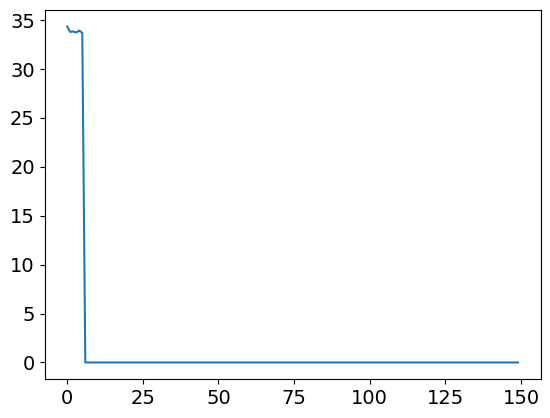

In [28]:
plt.plot(elapsed_time/1000)

In [29]:
print(elapsed_time.mean()/1000)
print(elapsed_time.std()/1000)

1.354065
6.633679058449262
